# Equilibrium states

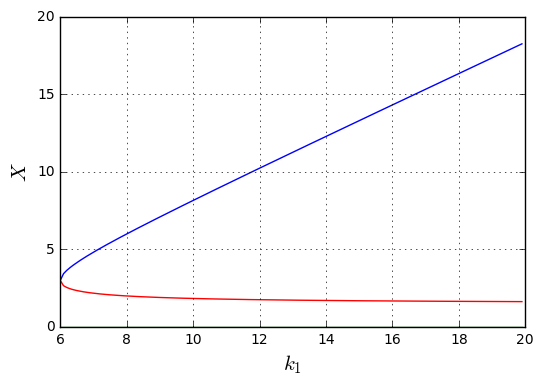

In [186]:
import math
X_1=[]
X_2=[]
k_1=[float(i)/10 for i in list(range(60,200,1))]
D=[]
for i in k_1:
    params=[i,1,1,1.5] #k1,k2,k3,k4
    X_1.append((-params[1]+math.sqrt(params[1]*params[1]-4*params[1]*params[2]*params[3]/params[0]))/(-2*params[1]*params[2]/params[0]))
    X_2.append((-params[1]-math.sqrt(params[1]*params[1]-4*params[1]*params[2]*params[3]/params[0]))/(-2*params[1]*params[2]/params[0]))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k_1,X_1,c='red')
plt.plot(k_1,X_2,c='blue')
plt.xlabel('$k_1$',size=15)
plt.ylabel('$X$',size=15)
plt.grid()

# Trajectories

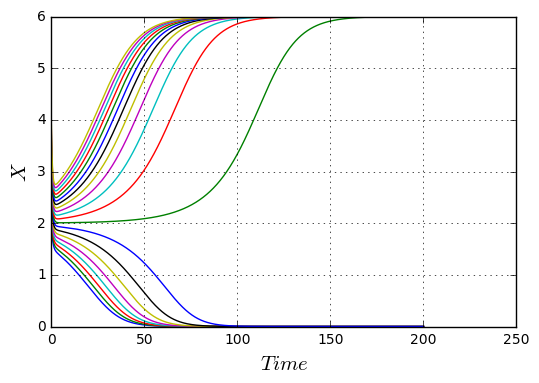

In [190]:
#Rate equations
def dX(X,Y,params,dt):
    return (2*params[0]*Y[-1]-params[1]*X[-1]*X[-1]-params[2]*X[-1]*Y[-1]-params[3]*X[-1])*dt

def dY(X,Y,params,dt):
    return (-params[0]*Y[-1]+params[1]*X[-1]*X[-1])*dt

#Trajectory function
def trajectory(params,dt,init,t):
    import pandas as pd
    run=pd.DataFrame(columns=['X','Y','t'])
    run=run.append(pd.DataFrame(data={'X':[init[0]],'Y':[init[1]],'t':[0]}))
    while list(run['t'])[len(run)-1]<t:
        next_X=dX(list(run['X']),list(run['Y']),params,dt)*dt+list(run['X'])[len(run)-1]
        next_Y=dY(list(run['X']),list(run['Y']),params,dt)*dt+list(run['Y'])[len(run)-1]
        next_t=list(run['t'])[len(run)-1]+dt
        run=run.append(pd.DataFrame(data={'X':[next_X],'Y':[next_Y],'t':[next_t]}))
    return run

import matplotlib.pyplot as plt
%matplotlib inline
for i in list(range(20,40,1)):
    init=[float(i)/10,0]
    params=[8,1,1,1.5] #k1,k2,k3,k4
    t=200
    dt=0.1
    run=trajectory(params,dt,init,t)
    plt.plot(run['t'],run['X'])

plt.xlabel('$Time$',size=15)
plt.ylabel('$X$',size=15)
plt.grid()
plt.show()

# Steady-states at different initial conditions

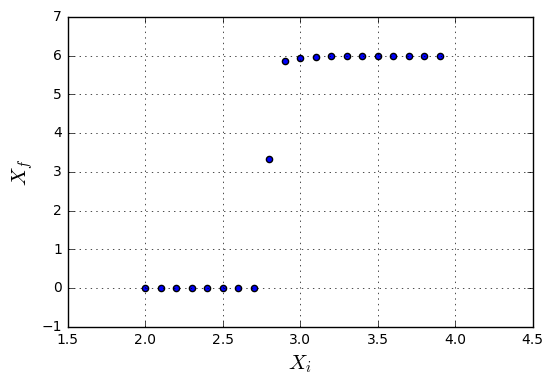

In [189]:
Xf=[]
Xi=[]
for i in list(range(20,40,1)):
    init=[float(i)/10,0]
    params=[8,1,1,1.5] #k1,k2,k3,k4
    t=100
    dt=0.1
    run=trajectory(params,dt,init,t)
    Xf.append(list(run['X'])[-1])
    Xi.append(float(i)/10)

plt.scatter(Xi,Xf)
plt.xlabel('$X_i$',size=15)
plt.ylabel('$X_f$',size=15)
plt.grid()
plt.show()